In [3]:
from __future__ import print_function
%matplotlib inline
%precision 8
import numpy
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 3: BVP Problems II

## Question 1

Consider the two-dimensional Poisson problem defined as
$$
    \nabla^2 u = f(x,y) ~~~~ \Omega = [0, 1] \times [0, 1]
$$
with Dirichlet boundary conditions $u(x,y)|_{\partial \Omega} = 0$.

Note that the notation $\partial \Omega$ often refers to the boundary of $\Omega$ and $u(x,y)|_{\partial \Omega}$ the solution evaluted at the boundary.

**(a)** [5] If we wanted to consider solutions of the form
$$
    u(x,y) = (y^3 - y) (\cos(2 \pi x) - 1)
$$
what should we require $f(x,y)$ to be?  Is this consistent with the boundary conditions?

The derivatives we need are
$$
    u_{xx} = -4 \pi^2 (y^3 - y) \cos(2 \pi x)
$$
and
$$
    u_{yy} = 6 y (\cos(2 \pi x) - 1)
$$
leading us to the function
$$
    f(x,y) = - 4 \pi^2 (y^3 - y) \cos(2\pi x) + 6 y (\cos(2\pi x) - 1)
$$

Since assumed solution $u(x,y) = 0$ along the boundaries specified are zero these are consistent with the boundary conditions.

**(b)** [10] Implement a finite difference method for the problem above with grid spacing $\Delta x = \Delta y$ using a 9-point Laplacian.

In [4]:
# Suggested modules to use to construct matrix A
# You do not have to use these, they just may be helpful
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

def solve_9point(m, f):
    ### BEGIN SOLUTION
    x = numpy.linspace(0, 1.0, m + 2)
    y = numpy.linspace(0, 1.0, m + 2)
    delta_x = 1.0 / (m + 1)

    # Construct A
    e = numpy.ones(m)
    T = sparse.spdiags([4.0 * e, -20.0 * e, 4.0 * e], [-1, 0, 1], m, m)
    I = sparse.eye(m)
    S = sparse.spdiags([e, e], [-1, 1], m, m)
    OI = sparse.spdiags([e, 4.0 * e, e], [-1, 0, 1], m, m)
    A = (sparse.kron(I, T) + sparse.kron(S, OI)).tocsr()
    A /= 6.0 * delta_x**2
    
    # Right-hand-side
    X, Y = numpy.meshgrid(x[1:-1], y[1:-1])
    b = f(X, Y).reshape(m**2, order='F')

    # Solve
    U = numpy.zeros((m+2, m+2))
    U[1:-1, 1:-1] = linalg.spsolve(A, b).reshape((m, m), order='F')

    ### END SOLUTION
    return x, y, U

In [5]:
f = lambda x, y: -(20.0 * y**3 + 9.0 * numpy.pi**2 * (y - y**5)) * numpy.sin(3.0 * numpy.pi * x)
u_true = lambda x, y: (y - y**5) * numpy.sin(3.0 * numpy.pi * x)

x, y, U = solve_9point(100, f)
X, Y = numpy.meshgrid(x, y)
error = numpy.linalg.norm((x[1] - x[0]) * (u_true(X, Y) - U), ord=1)
print(error)
assert error < 1e-3
### THIS IS SPARTA!
print("Success!")
### UPS... THIS IS NOT SPARTA

0.00026543132573227964
Success!


**(c)** [5] Show that the method is second-order accurate by preforming a convergence study (i.e. plot the error vs. $\Delta x$ and compare this to the slopes for first and second order accurate methods).

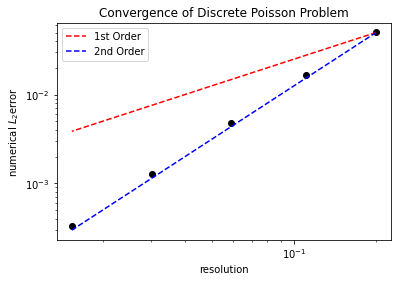

In [6]:
### BEGIN SOLUTION
# f = lambda x, y: -(20.0 * y**3 + 9.0 * numpy.pi**2 * (y - y**5)) * numpy.sin(3.0 * numpy.pi * x)
# u_true = lambda x, y: (y - y**5) * numpy.sin(3.0 * numpy.pi * x)
u_true = lambda x, y: (y**3 - y) * (numpy.cos(2.0 * numpy.pi * x) - 1.0)
f = lambda x, y: -4.0 * numpy.pi**2 * (y**3 - y) * numpy.cos(2.0 * numpy.pi * x) + 6.0 * y * (numpy.cos(2.0 * numpy.pi * x) - 1.0)

index   = numpy.asarray([2**k for k in numpy.arange(2,7)])
delta_x = numpy.zeros(len(index))
error   = numpy.zeros(len(index))

fig = plt.figure(1)

for k,m in enumerate(index):
    x, y, U    = solve_9point(m,f)
    X, Y       = numpy.meshgrid(x, y)
    delta_x[k] = x[1]-x[0]
    error[k]   = numpy.linalg.norm(delta_x[k] * (u_true(X,Y) - U), ord=1)
    
plt.loglog(delta_x,error,'ko')
plt.draw()

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
plt.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
plt.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
plt.legend()

plt.title('Convergence of Discrete Poisson Problem')
plt.xlabel('resolution')
plt.ylabel('numerical $L_2$error')
plt.show()
### END SOLUTION

**(d)** [15] Show that the 9-point Laplacian can be written as a 5-point Laplacian **plus** a finite difference approximation of $\frac{1}{6}h^2 u_{xxyy} + \mathcal O(h^4)$.

For the 9-point Laplacian we consider the Taylor expansions:  
$$\begin{aligned}
    u(x\pm \Delta x, y\pm \Delta x) &= u(x,y) \pm \Delta x ( u_x + u_y ) + \frac{\Delta x^2}{2} \left(u_{xx}+2u_{xy}+u_{yy} \right) + \mathcal O(\Delta x^3)\\
    u(x\mp \Delta x, y\pm \Delta x) &= u(x,y) \mp \Delta x ( u_x + u_y ) + \frac{\Delta x^2}{2} \left(u_{xx}-2u_{xy}+u_{yy}\right) + \mathcal O(\Delta x^3)\\
    u(x\pm \Delta x, y ) &=  u(x,y) \pm \Delta x u_x + \frac{\Delta x^2}{2} u_{xx} + \mathcal O(\Delta x^3)\\
    u(x, y\pm \Delta x ) &=  u(x,y) \pm \Delta x u_y + \frac{\Delta x^2}{2} u_{yy} + \mathcal O(\Delta x^3)
\end{aligned}$$

We take a weighted sum of these equations of the form _once each of the first four and four times each of the last four_.
This adds up to:

$$
  \frac{1}{6\Delta x^2} \left( u(x + \Delta x, y + \Delta x) +  u(x - \Delta x, y + \Delta x) +  4u(x + \Delta x, y) +  4u(x, y + \Delta x) +  \
   u(x - \Delta x, y - \Delta x) +  u(x + \Delta x, y - \Delta x) +  4u(x - \Delta x, y) +  4u(x, y - \Delta x) -  \
   20 u(x,y)\right)  = \left(u_{xx}+u_{yy} \right) + \mathcal O(\Delta x^3)
$$

So we define the 9-point Laplace as
$$
    \nabla_9^2 = \frac{1}{6\Delta x^2} \left( u(x + \Delta x, y + \Delta x) + u(x - \Delta x, y + \Delta x) +  4u(x + \Delta x, y) + 4 u(x, y + \Delta x) +  \
   u(x - \Delta x, y - \Delta x) +  u(x + \Delta x, y - \Delta x) + 4 u(x - \Delta x, y) + 4 u(x, y - \Delta x) -  \
   20 u(x,y)\right) 
$$


For the truncation error, we consider the Taylor expansions:
$$\begin{aligned}
   u(x\pm \Delta x, y\pm \Delta x) &= u(x,y) \pm \Delta x ( u_x + u_y ) + \
   \frac{\Delta x^2}{2} \left(u_{xx}+2u_{xy}+u_{yy} \right) \pm \
   \frac{\Delta x^3}{6} \left( u_{xxx} + 3 u_{xxy} + 3 u_{xyy} + u_{yyy} \right) + \\
   &\frac{\Delta x^4}{24} \left( u_{xxxx} + 4 u_{xxxy} + 6 u_{xxyy} + 4 u_{xyyy} + u_{yyyy} \right) + \
   \mathcal O(\Delta x^5)\\
    u(x\mp \Delta x, y\pm \Delta x) &= u(x,y) \mp \Delta x ( u_x + u_y ) + \
    \frac{\Delta x^2}{2} \left(u_{xx}-2u_{xy}+u_{yy}\right) + \
    \frac{\Delta x^3}{6} \left( \mp u_{xxx} \pm 3 u_{xxy} \mp 3 u_{xyy} \pm u_{yyy} \right) + \\
   &\frac{\Delta x^4}{24} \left( u_{xxxx} - 4 u_{xxxy} + 6 u_{xxyy} - 4 u_{xyyy} + u_{yyyy} \right) + \
   \mathcal O(\Delta x^5)\\
    u(x\pm \Delta x, y ) &=  u(x,y) \pm \Delta x u_x + \frac{\Delta x^2}{2} u_{xx} + \
     \pm \frac{\Delta x^3}{6}u_{xxx} + \frac{\Delta x^4}{24} u_{xxxx} +\mathcal O(\Delta x^5)\\
    u(x, y\pm \Delta x ) &=  u(x,y) \pm \Delta x u_y + \frac{\Delta x^2}{2} u_{yy} + \
     \pm \frac{\Delta x^3}{6} u_{yyy} + \frac{\Delta x^4}{24} u_{yyyy} + \mathcal O(\Delta x^5)
\end{aligned}$$  

Plugging those in to the formula for the 9-point Laplacian gives
$$\begin{aligned}
    \nabla_9^2 &= \Delta u + \Delta x^2 \frac{1}{6} \left( \frac{12}{24} u_{xxxx}+ \frac{24}{24} u_{xxyy} + \frac{12}{24} u_{yyyy}\right) + \mathcal O(\Delta x^5)\\
               &= \Delta u + \Delta x^2 \frac{1}{12} \left( u_{xxxx}+ 2 u_{xxyy} + u_{yyyy}\right) + \mathcal O(\Delta x^5),
\end{aligned}$$



so that the truncation error is

$$
    \tau(\nabla_9^2) = \frac{\Delta x^2}{12} \left( u_{xxxx}+ 2 u_{xxyy} + u_{yyyy}\right) + \mathcal O(\Delta x^5)
$$

So, the error is still of order $\mathcal O(\Delta x^2)$.

Let us assume that $\Delta x = \Delta y$. The 9-point Laplacian is given by 

$$
    \nabla_9^2 = \frac{1}{6\Delta x^2} \left( u(x + \Delta x, y + \Delta x) + u(x - \Delta x, y + \Delta x) +  4u(x + \Delta x, y) + 4 u(x, y + \Delta x) +  \
   u(x - \Delta x, y - \Delta x) +  u(x + \Delta x, y - \Delta x) + 4 u(x - \Delta x, y) + 4 u(x, y - \Delta x) -  \
   20 u(x,y)\right) 
$$

From the lecture we know that the truncation error for the 5-point Laplacian is

$$
    \tau(\nabla_5^2) = \frac{\Delta x^2}{12} \left( u_{xxxx} + u_{yyyy} \right) + \mathcal O(\Delta x^4)
$$

Subtracting this result from the answer above, we obtain

$$
    \tau(\nabla_9^2 - \nabla_5^2) = \Delta x^2 \frac{1}{6} \left( u_{xxyy} \right) + \mathcal O(\Delta x^4)
$$

**(e)** [10] Modify your function to use the trick introduced in class that will cause the 9-point Laplacian stencil to become 4th order accurate.  Show that this is true via a convergence study.

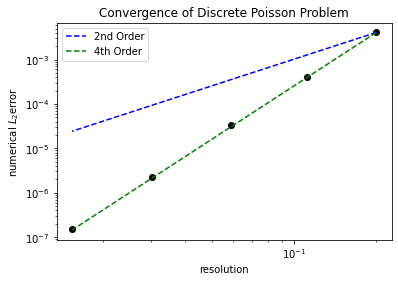

In [7]:
### BEGIN SOLUTION
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

def solve_9point_plus(m, f, laplace_f):
    x = numpy.linspace(0, 1.0, m + 2)
    y = numpy.linspace(0, 1.0, m + 2)
    delta_x = 1.0 / (m + 1)

    # Construct A
    e = numpy.ones(m)
    T = sparse.spdiags([4.0 * e, -20.0 * e, 4.0 * e], [-1, 0, 1], m, m)
    I = sparse.eye(m)
    S = sparse.spdiags([e, e], [-1, 1], m, m)
    OI = sparse.spdiags([e, 4.0 * e, e], [-1, 0, 1], m, m)
    A = (sparse.kron(I, T) + sparse.kron(S, OI)).tocsr()
    A /= 6.0 * delta_x**2
    
    # Right-hand-side
    X, Y = numpy.meshgrid(x[1:-1], y[1:-1])
    b = (f(X, Y) + delta_x**2 / 12.0 * laplace_f(X, Y)).reshape(m**2, order='F')

    # Solve
    U = numpy.zeros((m+2, m+2))
    U[1:-1, 1:-1] = linalg.spsolve(A, b).reshape((m, m), order='F')

    return x, y, U


u_true = lambda x, y: (y**3 - y) * (numpy.cos(2.0 * numpy.pi * x) - 1.0)
f = lambda x, y: -4.0 * numpy.pi**2 * (y**3 - y) * numpy.cos(2.0 * numpy.pi * x) + 6.0 * y * (numpy.cos(2.0 * numpy.pi * x) - 1.0)
laplace_f = lambda x, y: 16.0 * numpy.pi**4 * (y**3 - y) * numpy.cos(2.0 * numpy.pi * x) - 48.0 * numpy.pi**2 * y * numpy.cos(2.0 * numpy.pi * x)

index   = numpy.asarray([2**k for k in numpy.arange(2,7)])
delta_x = numpy.zeros(len(index))
error   = numpy.zeros(len(index))

fig = plt.figure(1)

for k,m in enumerate(index):
    x, y, U    = solve_9point_plus(m, f, laplace_f)
    X, Y       = numpy.meshgrid(x, y)
    delta_x[k] = x[1]-x[0]
    error[k]   = numpy.linalg.norm(delta_x[k] * (u_true(X,Y) - U), ord=1)
    
plt.loglog(delta_x,error,'ko')
plt.draw()

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
plt.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
plt.loglog(delta_x, order_C(delta_x[0], error[0], 4.0) * delta_x**4.0, 'g--', label="4th Order")
plt.legend()

plt.title('Convergence of Discrete Poisson Problem')
plt.xlabel('resolution')
plt.ylabel('numerical $L_2$error')
plt.show()
### END SOLUTION

## Question 2

Let us consider some modifications to the Gauss-Seidel method we discussed and when one version might be better than the other.

**(a)** [5] The Gauss-Seidel method for the discretization of $u''(x) = f(x)$
takes the form 
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k+1)}) - f(x_i) \frac{\Delta x^2}{2}
$$
if we assume we are marching forwards across the grid,
for $i=1,~2,~\ldots,~m$.  We can also define a *backwards Gauss-Seidel
method* by setting
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k+1)} + U_{i-1}^{(k)}) - f(x_i) \frac{\Delta x^2}{2}
$$
Show that this is a matrix splitting method of the type described in the lecture notes and what the splitting is.

We just need to simply show that we can write the iterative scheme with appropriate $M$ and $N$.  Using the terminology in the lecture notes we have $M = D-U$ and $N=L$.

**(b)** [5] Implement the backwards Gauss-Seidel method and show that the convergence is at the same rate as the forward version (do this computationally, you do not need to do this analytically).  Use the same expected iteration count as with the forwards method.

In [8]:
def solve_BGS(a, b, alpha, beta, m, f):
    ### BEGIN SOLUTION
    
    # Descretization
    x_bc = numpy.linspace(a, b, m + 2)
    x = x_bc[1:-1]
    delta_x = (b - a) / (m + 1)

    # Expected iterations needed
    iterations_GS = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - numpy.pi**2 * delta_x**2))

    # Solve system
    # Initial guess for iterations
    U = numpy.zeros(m + 2)
    U[0] = alpha
    U[-1] = beta
    success = False
    for k in range(iterations_GS):
        for i in range(m, 0, -1):
            U[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0
    ### END SOLUTION

    return x_bc, U

In [9]:
# Problem setup
a = 0.0
b = 1.0
alpha = 0.0
beta = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

x, U = solve_BGS(a, b, alpha, beta, 150, f)
error = numpy.linalg.norm((x[1] - x[0]) * (u_true(x) - U), ord=1)
print(error)
assert(error < 1e-4)
### BEGIN HIDDEN TESTS
print("Success!")
### END HIDDEN TESTS

4.595681653803634e-05
Success!


**(c)** [10] Modify the code so that it solves the steady-state problem
$$
    \epsilon u''(x) - u'(x) = f(x)
$$
we had before with the same boundaries and $f(x)$.  This time however use the one-sided approximation to the first derivative
$$
    \frac{U_i - U_{i-1}}{\Delta x}.
$$
Test both forward and backward Gauss-Seidel for the resulting linear system.  Use the value $\epsilon = 0.01$, $m = 100$, and a maximum number of iterations of $250$.  Plot the convergence of both approaches.

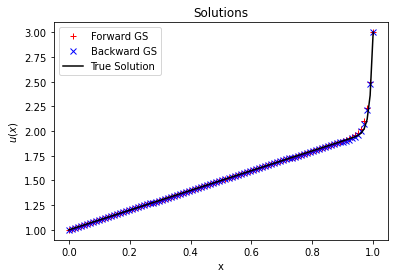

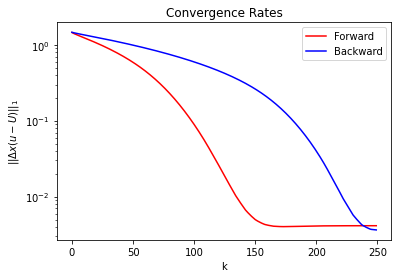

In [10]:
a = 0.0
b = 1.0
alpha = 1.0
beta = 3.0
epsilon = 0.01
u_true = lambda x: alpha + x + (beta - alpha - 1.0) * (numpy.exp(x / epsilon) - 1.0) / (numpy.exp(1.0 / epsilon) - 1.0)

### BEGIN SOLUTION
# Descretization
m = 100
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# max_iterations = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - numpy.pi**2 * delta_x**2))
max_iterations = 250
convergence = numpy.zeros((2, max_iterations))

# Forward GS
U_f = numpy.zeros(m + 2)
U_f[0] = alpha
U_f[-1] = beta
for k in range(max_iterations):
    for i in range(1, m + 1):
        U_f[i] = (epsilon * U_f[i+1] + (epsilon + delta_x) * U_f[i-1] + delta_x**2) / (2.0 * epsilon + delta_x)
    convergence[0, k] = numpy.linalg.norm(delta_x * (u_true(x_bc) - U_f), ord=1)

# Backward GS
U_b = numpy.zeros(m + 2)
U_b[0] = alpha
U_b[-1] = beta
for k in range(max_iterations):
    for i in range(m, 0, -1):
        U_b[i] = (epsilon * U_b[i+1] + (epsilon + delta_x) * U_b[i-1] + delta_x**2) / (2.0 * epsilon + delta_x)
    convergence[1, k] = numpy.linalg.norm(delta_x * (u_true(x_bc) - U_b), ord=1)    
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U_f, 'r+', label="Forward GS")
axes.plot(x_bc, U_b, 'bx', label="Backward GS")
axes.plot(x_bc, u_true(x_bc), 'k-', label="True Solution")
axes.set_title("Solutions")
axes.set_xlabel("x")
axes.set_ylabel("$u(x)$")
axes.legend(loc=2)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(convergence[0, :], 'r', label="Forward")
axes.semilogy(convergence[1, :], 'b', label="Backward")
axes.set_title("Convergence Rates")
axes.set_xlabel("k")
axes.set_ylabel("$ ||\Delta x(u - U)||_1$")
axes.legend(loc=1)

plt.show()
### END SOLUTION

**(d)** [5] Explain intuitively why sweeping in one direction works so much better than
in the other.

**Hint**: Note that this equation is the steady equation for an advection-diffusion PDE 
$$
    u_t(x,t) + u_x(x,t) = \epsilon u_{xx}(x,t) - f(x).
$$  
You might consider how the methods behave in the case $\epsilon = 0$.

There should be marked difference between the forward and backward sweeps due to the one-sided approximation.  Clearly the non-updated sweep in the backward direction is impacting the convergence.  This has more to do with the upwinding of the advective term than anything else.  If $\epsilon$ is small than this acts more like a hyperbolic PDE in which we would expect there to be more of instability one direction.  Given that we have not covered this, the above explanation is fine, the sweep direction clearly has a preference when using one-sided differences due to the dependence.

## Question 3 - Poisson on a Rectangle

**(a)** [15] Write a function that solves the Poisson problem 
$$
    \nabla^2 u = \frac{5}{4} e^{x + y/2}
$$
on $\Omega = [0, 1] \times [0, 2]$ using a five point stencil.  Use the true solution of the problem
$$
    u(x, y) = e^{x + y / 2}
$$
to set the boundary conditions.  Allow for $\Delta x$ and $\Delta y$ to be non-uniform.

In [11]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

def solve_poisson(X, Y, f):
    # BEGIN SOLUTION
    
    # Grid parameters
    delta_x = X[1, 0] - X[0, 0]
    delta_y = Y[0, 1] - Y[0, 0]
    
    # Construct A
    m = X.shape[0] - 2
    n = Y.shape[1] - 2
    
    e = numpy.ones(m)
    en = numpy.ones(n)
    
    T = sparse.spdiags([e / delta_x**2, -2.0 * e / delta_x**2 - 2.0 * e / delta_y**2, e / delta_x**2], [-1, 0, 1], m, m)
    S = sparse.spdiags([e / delta_y**2], [0], m, m)
    
    I = sparse.eye(n)
    I2 = sparse.spdiags([en], [1], n, n)
    I3 = sparse.spdiags([en], [-1], n, n)
    
    A = sparse.kron(I, T) + sparse.kron(I2, S) + sparse.kron(I3, S)
    
    # Construct rhs
    b = f(X[1:-1, 1:-1], Y[1:-1, 1:-1])

    # Boundaries - Note that this looks weird due to the resulting ordering
    b[0, :] -= numpy.exp(X[0, 1:-1] + Y[0, 1:-1] / 2.0) / delta_x**2    
    b[-1, :] -= numpy.exp(X[-1, 1:-1] + Y[-1, 1:-1] / 2.0) / delta_x**2
    b[:, 0] -= numpy.exp(X[1:-1, 0] + Y[1:-1, 0] / 2.0) / delta_y**2
    b[:, -1] -= numpy.exp(X[1:-1, -1] + Y[1:-1, -1] / 2.0) / delta_y**2

    U = numpy.exp(X + Y / 2.0)
    U[1:-1, 1:-1] = linalg.spsolve(A, b.reshape(m*n, order='F')).reshape((m, n), order='F')
    
    # END SOLUTION
    return U

Success!


/home/codio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/codio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


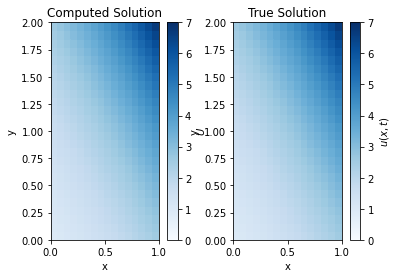

In [12]:
# Grid including boundaries
# Note that the x and y arrays include the boundary location
m = 15
n = 25
delta_x = 1.0 / (m + 1)
delta_y = 2.0 / (n + 1)
x = numpy.linspace(0.0, 1.0, m + 2)
y = numpy.linspace(0.0, 2.0, n + 2)
X, Y = numpy.meshgrid(x, y)
# Transpose these so that the coordinates match up to (i, j)
X = X.transpose()
Y = Y.transpose()

f = lambda x, y: 1.25 * numpy.exp(x + y / 2.0)
u_true = lambda x, y: numpy.exp(x + y / 2.0)
U = solve_poisson(X, Y, f)
assert numpy.linalg.norm(max(delta_x, delta_y) * (u_true(X, Y) - U), ord=1) < 1e-3
### BEGIN HIDDEN TESTS
print("Success!")
### END HIDDEN TESTS

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth())
axes = fig.add_subplot(1, 2, 1, aspect='equal')
plot = axes.pcolor(X, Y, U, vmax=7.0, vmin=0.0, cmap=plt.get_cmap("Blues"))
fig.colorbar(plot, label="$U$")
axes.set_title("Computed Solution")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes = fig.add_subplot(1, 2, 2, aspect='equal')
plot = axes.pcolor(X, Y, u_true(X, Y), vmax=7.0, vmin=0.0, cmap=plt.get_cmap("Blues"))
fig.colorbar(plot, label="$u(x,t)$")
axes.set_title("True Solution")
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

**(b)** [15] Keeping $\Delta x$ constant study the convergence behavior as $\Delta y \rightarrow 0$.  Do the same for $\Delta x$.  Comment on what you observe.

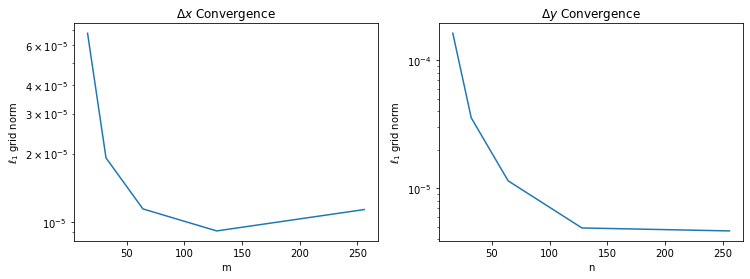

In [13]:
### BEGIN SOLUTION
f = lambda x, y: 1.25 * numpy.exp(x + y / 2.0)
u_true = lambda x, y: numpy.exp(x + y / 2.0)

# Perform x-sweep
n = 64
delta_y = 2.0 / (n + 1)
x_norm = numpy.empty(5)
for (i, m) in enumerate([2**k for k in range(4, 9)]):
    delta_x = 1.0 / (m + 1)
    x = numpy.linspace(0.0, 1.0, m + 2)
    y = numpy.linspace(0.0, 2.0, n + 2)
    X, Y = numpy.meshgrid(x, y)
    X = X.transpose()
    Y = Y.transpose()

    U = solve_poisson(X, Y, f)
    x_norm[i] = numpy.linalg.norm(max(delta_x, delta_y) * (u_true(X, Y) - U), ord=1)

# Perform y-sweep
m = 64
delta_x = 1.0 / (m + 1)
y_norm = numpy.empty(5)
for (i, n) in enumerate([2**k for k in range(4, 9)]):
    delta_y = 2.0 / (n + 1)
    x = numpy.linspace(0.0, 1.0, m + 2)
    y = numpy.linspace(0.0, 2.0, n + 2)
    X, Y = numpy.meshgrid(x, y)
    X = X.transpose()
    Y = Y.transpose()

    U = solve_poisson(X, Y, f)
    y_norm[i] = numpy.linalg.norm(max(delta_x, delta_y) * (u_true(X, Y) - U), ord=1)
    
# Plots
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.semilogy([2**k for k in range(4, 9)], x_norm)
axes.set_title("$\Delta x$ Convergence")
axes.set_xlabel("m")
axes.set_ylabel("$\ell_1$ grid norm")

axes = fig.add_subplot(1, 2, 2)
axes.semilogy([2**k for k in range(4, 9)], y_norm)
axes.set_title("$\Delta y$ Convergence")
axes.set_xlabel("n")
axes.set_ylabel("$\ell_1$ grid norm")

plt.show()

### END SOLUTION

One should see that eventually the convergence does not extend past a certain point due to the limited accuracy in the other direction.